# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGA's over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '',regex=True).str.upper()
seifa['LGA'] = lga
seifa.head()

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data frame to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


**Question 1-Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?**

We can count the used voucher values in each LGA- I'll pick the 10 LGA's that made use of the vouchers the most

In [6]:
LGA_counts=sa_vouchers_scores['Participant_LGA'].value_counts().rename_axis('Participant_LGA').to_frame('Used Voucher')

In [7]:
LGA_counts['count_percent']=LGA_counts['Used Voucher']/ LGA_counts['Used Voucher'].sum()
LGA_counts.iloc[:10]

,Used Voucher,count_percent
Participant_LGA,,
ONKAPARINGA,12782,0.100231
SALISBURY,8169,0.064058
TEA TREE GULLY,7219,0.056608
PLAYFORD,6940,0.054420
CHARLES STURT,6897,0.054083
PORT ADELAIDE ENFIELD,6384,0.050060
MARION,5291,0.041490
ADELAIDE HILLS,4756,0.037294
MITCHAM,4662,0.036557


The next line doesn't add to the other steps but is a good indicator of how uneven the voucher usage is. Since we can see that 10 LGA's use more that 50% of all vouchers.

In [8]:
normal_LGA=sa_vouchers_scores['Participant_LGA'].value_counts(normalize=True)
normal_LGA.iloc[:10].sum()

0.5220033561783479

Lets also add the population information of those LGA's

In [9]:
LGA_counts=LGA_counts.join(LGA_scores['Population'], on='Participant_LGA')


In [10]:
LGA_counts['population_percent']=LGA_counts['Used Voucher']/LGA_counts['Population']
LGA_counts

,Used Voucher,count_percent,Population,population_percent
Participant_LGA,,,,
ONKAPARINGA,12782,0.100231,159517.0,0.080129
SALISBURY,8169,0.064058,129067.0,0.063293
TEA TREE GULLY,7219,0.056608,95461.0,0.075623
PLAYFORD,6940,0.054420,79082.0,0.087757
CHARLES STURT,6897,0.054083,104922.0,0.065735
...,...,...,...,...
FRANKLIN HARBOUR,155,0.001215,1271.0,0.121951
ORROROO/CARRIETON,137,0.001074,871.0,0.157290
FLINDERS RANGES,102,0.000800,1703.0,0.059894


Let's leave the first 10 LGA's and group the rest together so we can create a clear pie chart to see the voucher usage.

In [11]:
Lga_vouchers_first10=LGA_counts['Used Voucher'].iloc[:11]
Lga_vouchers_first10=pd.DataFrame(Lga_vouchers_first10)

In [12]:
Lga_vouchers_other=LGA_counts['Used Voucher'].iloc[11:].sum()
Lga_vouchers_other= pd.DataFrame({'Used Voucher': [Lga_vouchers_other]},index=['Other'])
Lga_vouchers_first10 = pd.concat([Lga_vouchers_first10, Lga_vouchers_other], axis = 0)
Lga_vouchers_first10

,Used Voucher
ONKAPARINGA,12782
SALISBURY,8169
TEA TREE GULLY,7219
PLAYFORD,6940
CHARLES STURT,6897
PORT ADELAIDE ENFIELD,6384
MARION,5291
ADELAIDE HILLS,4756
MITCHAM,4662
MOUNT BARKER,3469


Text(0, 1, 'Voucher Usage per LGA')

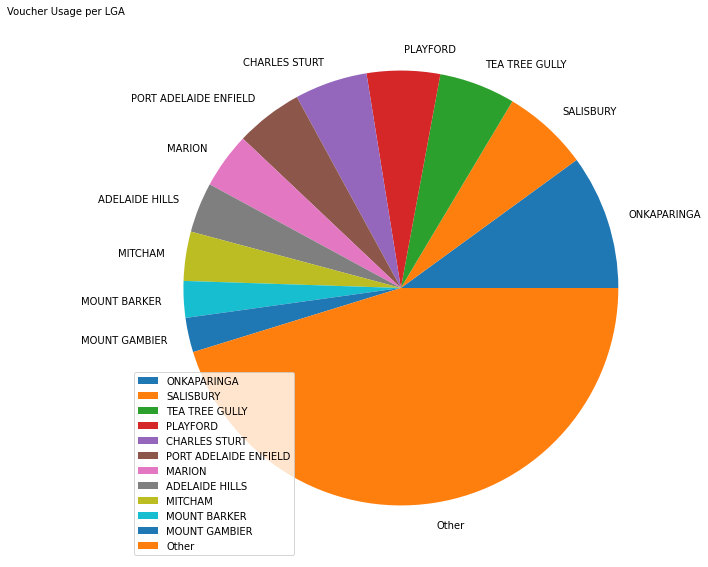

In [13]:
plt.rcParams.update({'font.size':10})
Lga_vouchers_first10.plot(kind='pie',y=('Used Voucher'),figsize=(10,10)).set_ylabel('Voucher Usage per LGA', rotation='horizontal', loc='top',fontsize='medium')

**-Some analysis- <br>**
We can see that the 11 LGA's cover more than 50% of used vouchers. Since there are 69 LGA'S in total we can say that the usage isn't scattered equally. LGA's like ONKAPARINGA, SALISBURY, TEA TREE GULLY, PLAYFORD and CHARLES STURT made use of the vouchers the most.

I'll do the same for sports- I'm just interested in the most popular sports so I pick the first 6 rows.

In [14]:
sport_counts=sa_vouchers_scores['Voucher_Sport'].value_counts()
sport_counts_first6=sport_counts.iloc[:6]
sport_counts_first6=pd.DataFrame(sport_counts_first6)
sport_counts_first6

,Voucher_Sport
Australian Rules,47224
Netball,24017
Football (Soccer),15775
Gymnastics,9823
Basketball,6016
Athletics,4518


In [15]:
sport_counts_other=sport_counts.iloc[6:].sum()

In [16]:
other_sportscounts= pd.DataFrame({'Voucher_Sport': [sport_counts_other]},index=['Other'])
sport_counts_first6 = pd.concat([sport_counts_first6, other_sportscounts], axis = 0)
sport_counts_first6

,Voucher_Sport
Australian Rules,47224
Netball,24017
Football (Soccer),15775
Gymnastics,9823
Basketball,6016
Athletics,4518
Other,20153


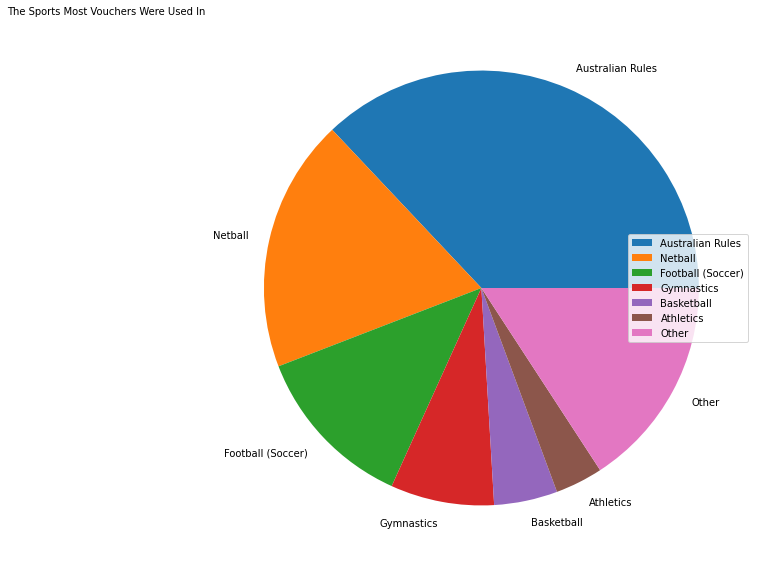

In [17]:
sport_counts_first6.plot(kind='pie',y=('Voucher_Sport'),figsize=(10,10),fontsize=10).set_ylabel('The Sports Most Vouchers Were Used For', rotation='horizontal', loc='top',fontsize='medium')
plt.legend(loc='center right')

We can see that there is not much variation when people pick which sports to use their vouchers for. The most popular 6 sports make up almost 85% of all vouchers used.

**-Some analysis- <br>**
We can clearly see that there is a big difference in the vouchers used by LGA's **ONKAPARINGA** with almost 13000 vouchers used and then **SALISBURY** with around 8000 vouchers and then **TEA TREE GULLY** with around 7000 vouchers used. <br>
We can see a similar pattern with the sports. **Australian Rules(47224)** is by far the most attended sport with almost twice as much vouchers used for than the second sport **Netball(24017)** and the third most polular sport is **Soccer** with around 15000 vouchers being used for it. <br>
We can also see that the 10 LGA's that used the vouchers the most make up to almost 50% of all used vouchers <br>
We see an even more skewed pattern with the sports the vouchers were used for since the most popular 6 sports make up almost 87% percent of all vouchers used. <br>
Promoting less popular sports could raise awareness and encourage kids to learn those sports.

**Question 2-Are some sports more popular in different parts of the state?**

In [18]:
sport_based=pd.DataFrame(sa_vouchers_scores)
sport_based=sport_based.drop(['Club_Previous_Member','Participant_Suburb','Participant_ATSI_Indicator','Participant_CALD_Indicator','Participant_Sex','Voucher_Value','Club_Name','Participant_Electorate','Voucher_Completion_Date','Voucher_Claim_Year','IEO','IER','IRSAD','IRSAD','IRSD','Participant_ID','Population'], axis=1)

In [19]:
sport_based.set_index(['Participant_LGA'],inplace = True)
sport_based=sport_based.groupby(["Participant_LGA", "Voucher_Sport"],as_index=False).size().pivot(index="Participant_LGA", columns="Voucher_Sport",values='size').fillna(0)
sport_based

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,0.0,16.0,130.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,...,0.0,0.0,0.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0
ADELAIDE HILLS,3.0,204.0,1412.0,2.0,0.0,11.0,48.0,0.0,62.0,128.0,...,0.0,18.0,3.0,44.0,257.0,2.0,1.0,1.0,0.0,0.0
ADELAIDE PLAINS,0.0,3.0,485.0,0.0,0.0,3.0,15.0,0.0,23.0,3.0,...,0.0,3.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
ALEXANDRINA,9.0,62.0,980.0,4.0,3.0,0.0,204.0,0.0,5.0,8.0,...,2.0,11.0,0.0,0.0,109.0,0.0,0.0,0.0,0.0,0.0
BAROSSA,0.0,158.0,1196.0,3.0,0.0,6.0,341.0,0.0,9.0,56.0,...,0.0,12.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,1.0,114.0,907.0,2.0,0.0,12.0,70.0,0.0,45.0,85.0,...,0.0,80.0,4.0,27.0,158.0,1.0,4.0,2.0,0.0,0.0
WHYALLA,0.0,15.0,569.0,0.0,0.0,0.0,605.0,0.0,15.0,12.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WUDINNA,0.0,29.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 159.0, 'Voucher Sport')

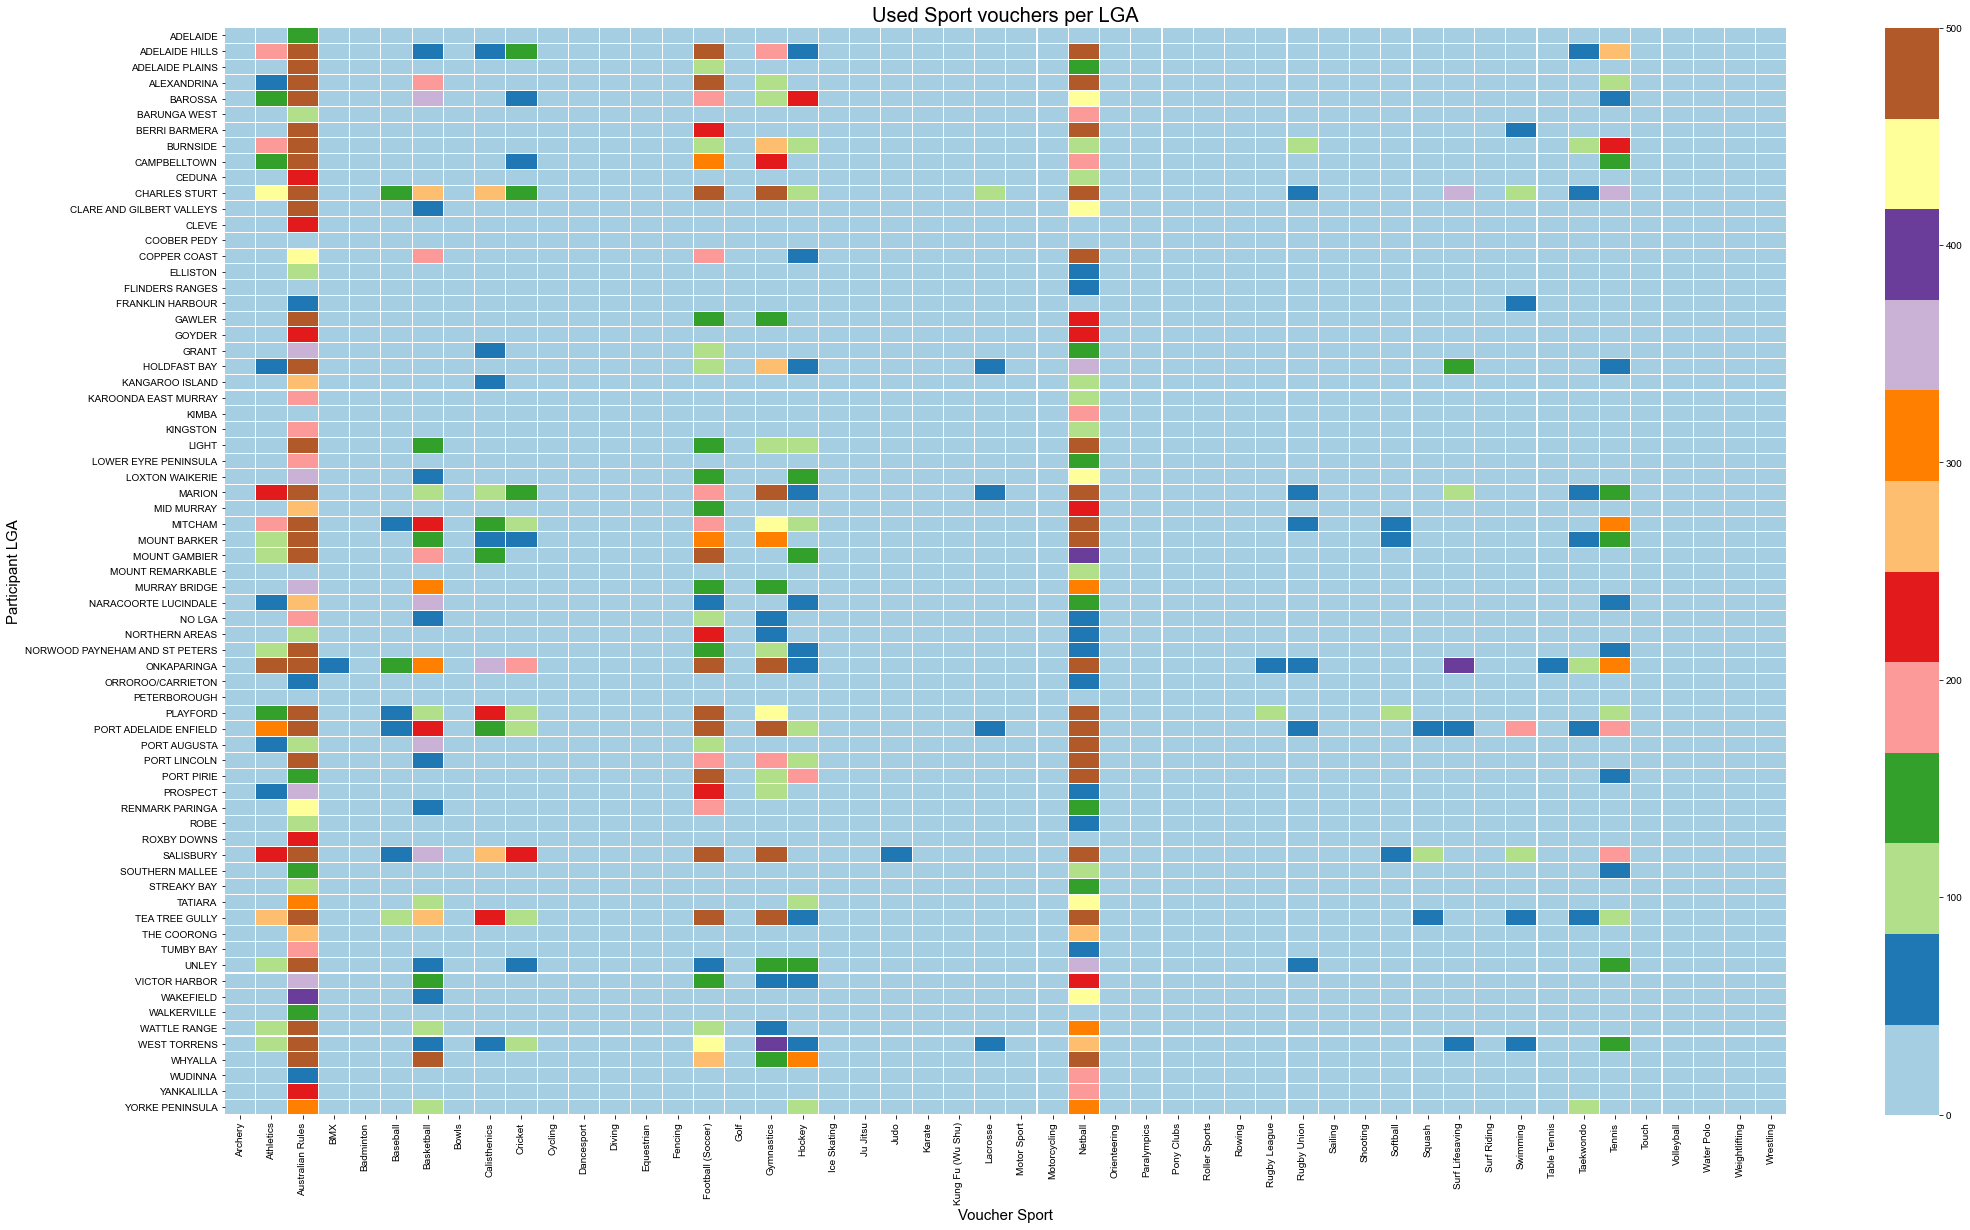

In [20]:
plt.figure(figsize=(35,20))
plt.title("Used Sport vouchers per LGA", fontsize =20)
ax = sns.heatmap(sport_based,vmin=0,vmax=500, linewidths=.05,cmap='Paired')
sns.set(font_scale=0.8)
plt.ylabel("Participant LGA",fontsize=15)
plt.xlabel("Voucher Sport",fontsize=15)

**Some Analysis** <br>
We can see that some sports are popular in most of the LGA's for example:; Australian Football , Netball, Basketball,Soccer ,Gymnastics and Hockey. But some Sports are only popular (considering the voucher usage)in a few LGA's. Salisbury is one of the LGA's that used the vouchers for different sports in anddition to the popular ones. For example around 50 vouchers were used for Judo in SALISBURY. Another interesting instance is with Lacrosse. We can see that the vouchers were only used for Lacrosse in 5 LGA's; Charles Sturt, Holdfast Bay, Marion, Port Adelaide Enfield and West Torrens. Another interesting sport is the Rugby League, which only had vouchers used for in Playford and Onkaparinga. <br>
It is also important to note here that most of the LGA's that used their vouchers for sports other that the most popular ones are the LGA's that made use of the vouchers the most(e.g., Salisbury, Charles Sturt, Marion, Port Adelaide Enfield, Onkaparinga ). So we can say that most of these LGA'S played unconbventional sports in addition to the popular ones.

**Question 3** <br>
Are any LGA's over/under represented in their use of vouchers?

I will use the same dataframe we created in question 1 since it has information about voucher usage per population.I will first sort the data by population percent in descending order and drop the null values. We had already commented on the difference in 'population_percent' for each LGA. We can cleary see that some LGA's made more use of vouchers.

In [21]:
LGA_counts_sorted = LGA_counts.sort_values(["population_percent"], ascending=False)
LGA_counts_sorted = LGA_counts_sorted.dropna(subset=['population_percent'], axis=0)
LGA_counts_sorted

,Used Voucher,count_percent,Population,population_percent
Participant_LGA,,,,
KAROONDA EAST MURRAY,388,0.003043,1035.0,0.374879
KIMBA,232,0.001819,1087.0,0.213431
WUDINNA,267,0.002094,1256.0,0.212580
CLEVE,329,0.002580,1729.0,0.190283
SOUTHERN MALLEE,342,0.002682,2097.0,0.163090
...,...,...,...,...
CAMPBELLTOWN,2567,0.020129,97060.0,0.026448
PETERBOROUGH,45,0.000353,1733.0,0.025967
COOBER PEDY,39,0.000306,1694.0,0.023022


Text(0.5, 0, 'Participant LGA')

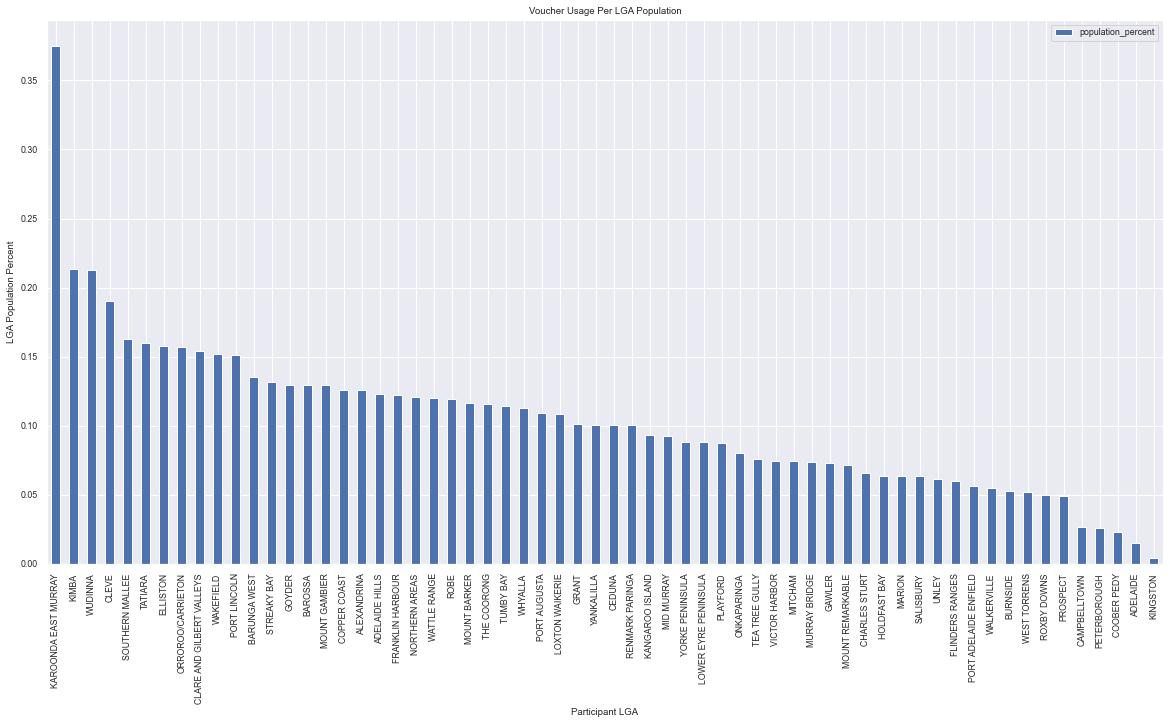

In [22]:
ax = LGA_counts_sorted.plot.bar(y='population_percent', rot=0,figsize=(20,10))
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Voucher Usage Per LGA Population")
plt.ylabel("LGA Population Percent")
plt.xlabel("Participant LGA")

**-Some analysis- <br>**
We can see that some LGA's used more vouchers per population than others. The LGA's on the left side of the plot (KAROONDA EAST MURRAY,KIMBA,WUDINNA etc.) can be considered overrepresented whereas the LGA'S on the right side of the plot (KINGSTON,ADELAIDE,COOBER PEDY) are underrepresented. KINGSTON is greatly underrepresented with around 0.004% of it's population making use of vouchers.

**Question 4- Is there a relationship between any of the SEIFA measures and voucher use in an LGA?**


Let's use the IRSD-(Relative Socio-economic Disadvantage) and IRSAD-( Relative Socio-economic Advantage and Disadvantage)

In [23]:
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [24]:
sa_vouchers_scores.head()
seifa_score1=sa_vouchers_scores.drop(['Participant_ID','Participant_Suburb','Club_Previous_Member','Participant_ATSI_Indicator','Participant_CALD_Indicator','Participant_Sex','Voucher_Value','Club_Name','Voucher_Sport','Participant_Electorate','Voucher_Completion_Date','Voucher_Claim_Year','IEO','IER','Population'], axis=1)
seifa_score1=seifa_score1.groupby(['Participant_LGA']).mean()

In [25]:
seifa_score1=seifa_score1.join(LGA_counts['Used Voucher'], on='Participant_LGA')
seifa_score1 = seifa_score1.dropna(subset=['IRSAD','IRSD'], axis=0)
seifa_score1

,IRSAD,IRSD,Used Voucher
Participant_LGA,,,
ADELAIDE,1036.0,1013.0,302
ADELAIDE HILLS,1077.0,1081.0,4756
ALEXANDRINA,969.0,987.0,2979
BAROSSA,997.0,1017.0,2874
BARUNGA WEST,940.0,954.0,333
...,...,...,...
WEST TORRENS,989.0,998.0,2844
WHYALLA,897.0,905.0,2488
WUDINNA,999.0,1023.0,267


Text(0.5, 1.0, 'IRSD score and voucher usage correlation')

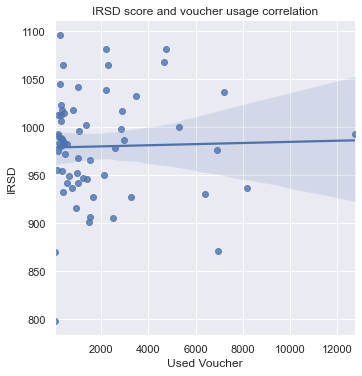

In [26]:
sns.set(font_scale=1.0)
IRSD_CORR=sns.lmplot(x='Used Voucher',y='IRSD', data=seifa_score1)
plt.title("IRSD score and voucher usage correlation")

And another plot for 'IRSAD'

Text(0.5, 1.0, 'IRSAD score and voucher usage correlation')

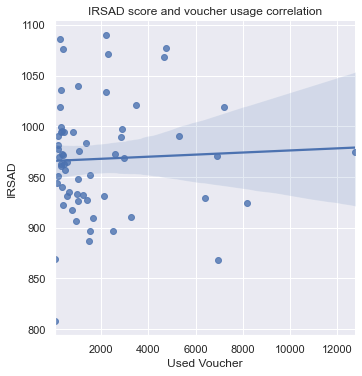

In [27]:
IRSAD_CORR=sns.lmplot(x='Used Voucher',y='IRSAD', data=seifa_score1)
plt.title("IRSAD score and voucher usage correlation")


With both plots we can see that many of the LGA'S that made use of the vouchers have IRSD scores between 900-1050 and mostly LGA'S used around 0-4000 vouchers. <br>
We can see the same pattern with IRSAD scores. Mostly LGA'S with 900-1050 IRSAD scores made use of the vouchers. <br>
We can't conclude any negative or positive correlation looking at these plots. <br>
If we look at the line of best fit in both score types(IRSD,IRSAD) we can see that 

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [28]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [29]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

<ipython-input-29-d688531e2bfc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0


Let's create a bar chart of the most popular sports like we did for the SA data.

In [30]:
qld_sport_counts=qld_vouchers_scores['Participation Activity'].value_counts()
qld_sport_counts=pd.DataFrame(qld_sport_counts)
qld_sport_counts_first6=qld_sport_counts.iloc[:6]
qld_sport_counts_first6=pd.DataFrame(qld_sport_counts_first6)

In [31]:
qld_sport_counts_other=qld_sport_counts.iloc[6:].sum()
qld_other_sportscounts= pd.DataFrame({'Participation Activity': [1925]},index=['Other'])
qld_sport_counts_first6= pd.concat([qld_sport_counts_first6, qld_other_sportscounts], axis = 0)
qld_sport_counts_first6

,Participation Activity
Rugby League,2782
Football (Soccer),2074
Netball,1263
Australian Football,548
Gymnastics,539
Basketball,376
Other,1925


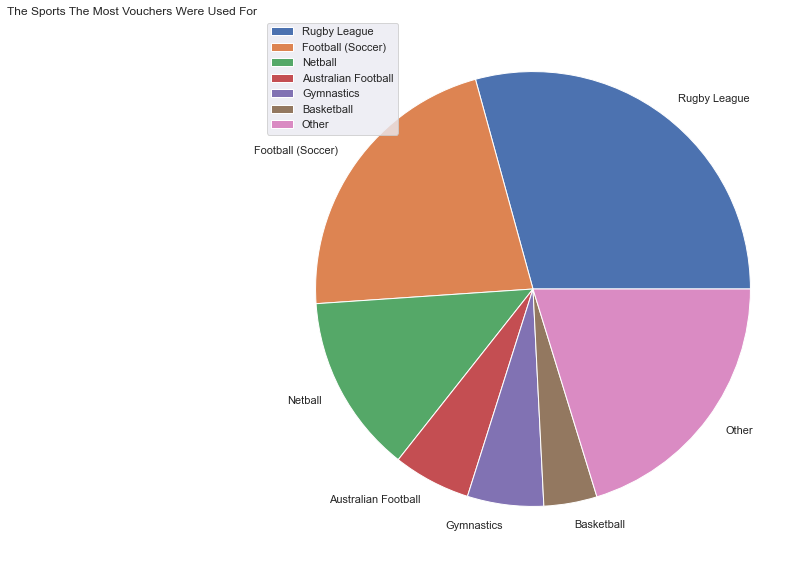

In [39]:
qld_sport_counts_first6.plot(kind='pie',y=('Participation Activity'),figsize=(10,10)).set_ylabel('The Sports The Most Vouchers Were Used For',rotation='horizontal', loc='top',fontsize='medium')
plt.legend(loc='upper left')

Text(0.5, 0, 'Sport Names')

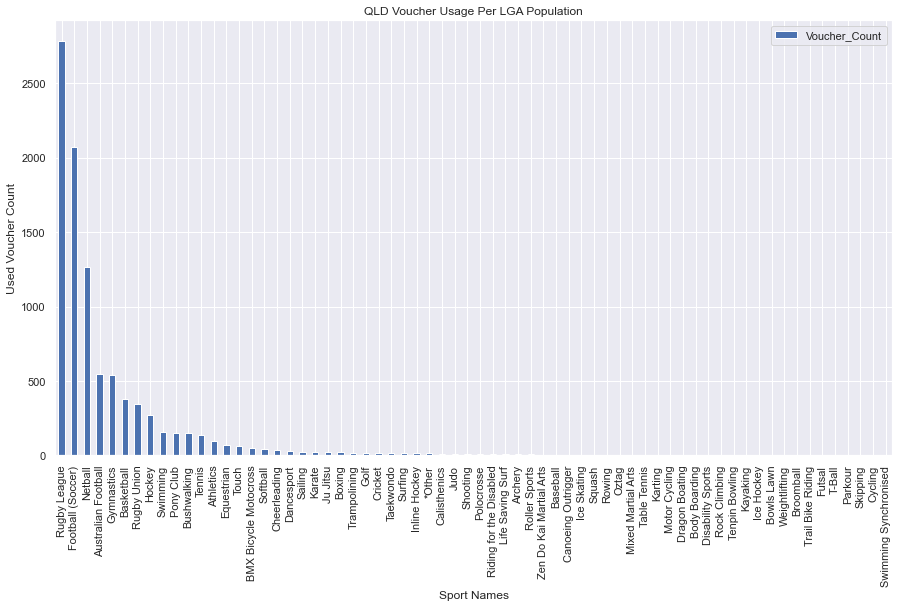

In [33]:
qld_sport_counts.rename(columns={'Participation Activity': 'Voucher_Count'}, inplace=True)
qld_sports = pd.DataFrame(qld_sport_counts).plot.bar(y='Voucher_Count', rot=0, figsize=(15,8))
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("QLD Voucher Usage Per LGA Population")
plt.ylabel("Used Voucher Count")
plt.xlabel("Sport Names")

In [34]:
sport_counts=pd.DataFrame(sport_counts)
sport_counts.rename(columns={'Voucher_Sport' : 'Voucher_Count'}, inplace=True)
sport_counts.rename(index={'Australian Rules':'Australian Football'},inplace=True)
sport_counts.rename(index={'Pony Clubs':'Pony Club'},inplace=True)
sport_counts.rename(index={'BMX':'BMX Bicycle Motocross'},inplace=True)
sport_counts.rename(index={'Surf Riding':'Surfing'},inplace=True)
sport_counts.rename(index={'Surf Lifesaving':'Lifesaving Surf'},inplace=True)
sport_counts.rename(index={'Motorcycling':'Motor Cycling'},inplace=True)
sport_counts.rename(index={'Paralympics':'Disability Sports'},inplace=True)
sport_counts.rename(index={'Bowls':'Bowls Lawn'},inplace=True)
sport_counts.rename(index={'Orienteering':'Trail Bike Riding'},inplace=True)

Text(0.5, 0, 'Sport Names')

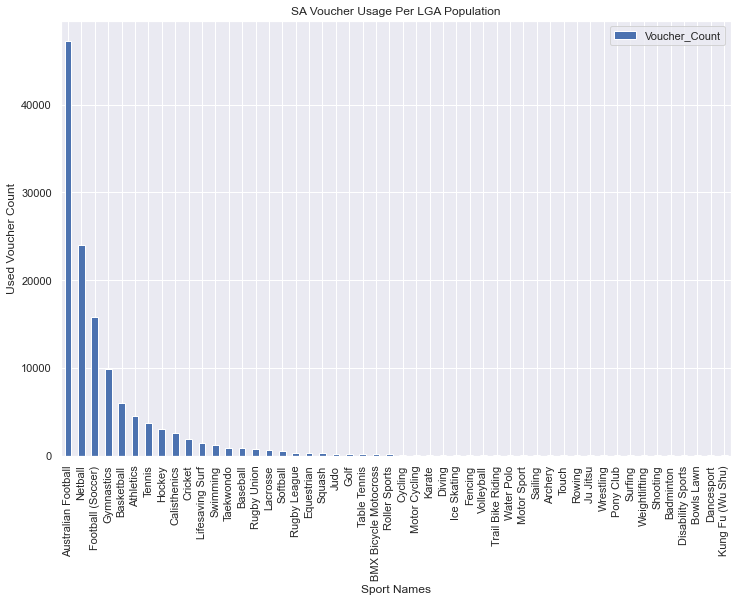

In [35]:
Sa_sports = pd.DataFrame(sport_counts).plot.bar(y='Voucher_Count', rot=0,figsize=(12,8))
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("SA Voucher Usage Per LGA Population")
plt.ylabel("Used Voucher Count")
plt.xlabel("Sport Names")

In [36]:
qld_sport_counts = qld_sport_counts.rename_axis('Sport name')
sport_counts=sport_counts.rename_axis('Sport name')
sport_counts.rename(columns={'Voucher_Count' : 'Voucher_Count_SA'}, inplace=True)

From the two plots we can see that there is a big voucher usage difference and while the SA voucher usage is high the QLD numbers are lower. Let's normalize the voucher usage so we can comment on the two states interest in different sports. 

In [37]:
SA_total__voucher_usage=sum(sport_counts['Voucher_Count_SA'])
sport_counts['Voucher_Count_SA_normal']=(sport_counts['Voucher_Count_SA'])/SA_total__voucher_usage
QLD_total_voucher_usage=sum(qld_sport_counts['Voucher_Count'])
qld_sport_counts['Voucher_Count_QLD_normal']=(qld_sport_counts['Voucher_Count'])/QLD_total_voucher_usage
qld_sport_counts=qld_sport_counts.drop('Voucher_Count', axis=1)
sport_counts=sport_counts.drop('Voucher_Count_SA', axis=1)

And finally let's create a Bar Chart to compare the popularity of the sports in QLD and SA.

Text(0, 0.5, 'Normalised used voucher numbers')

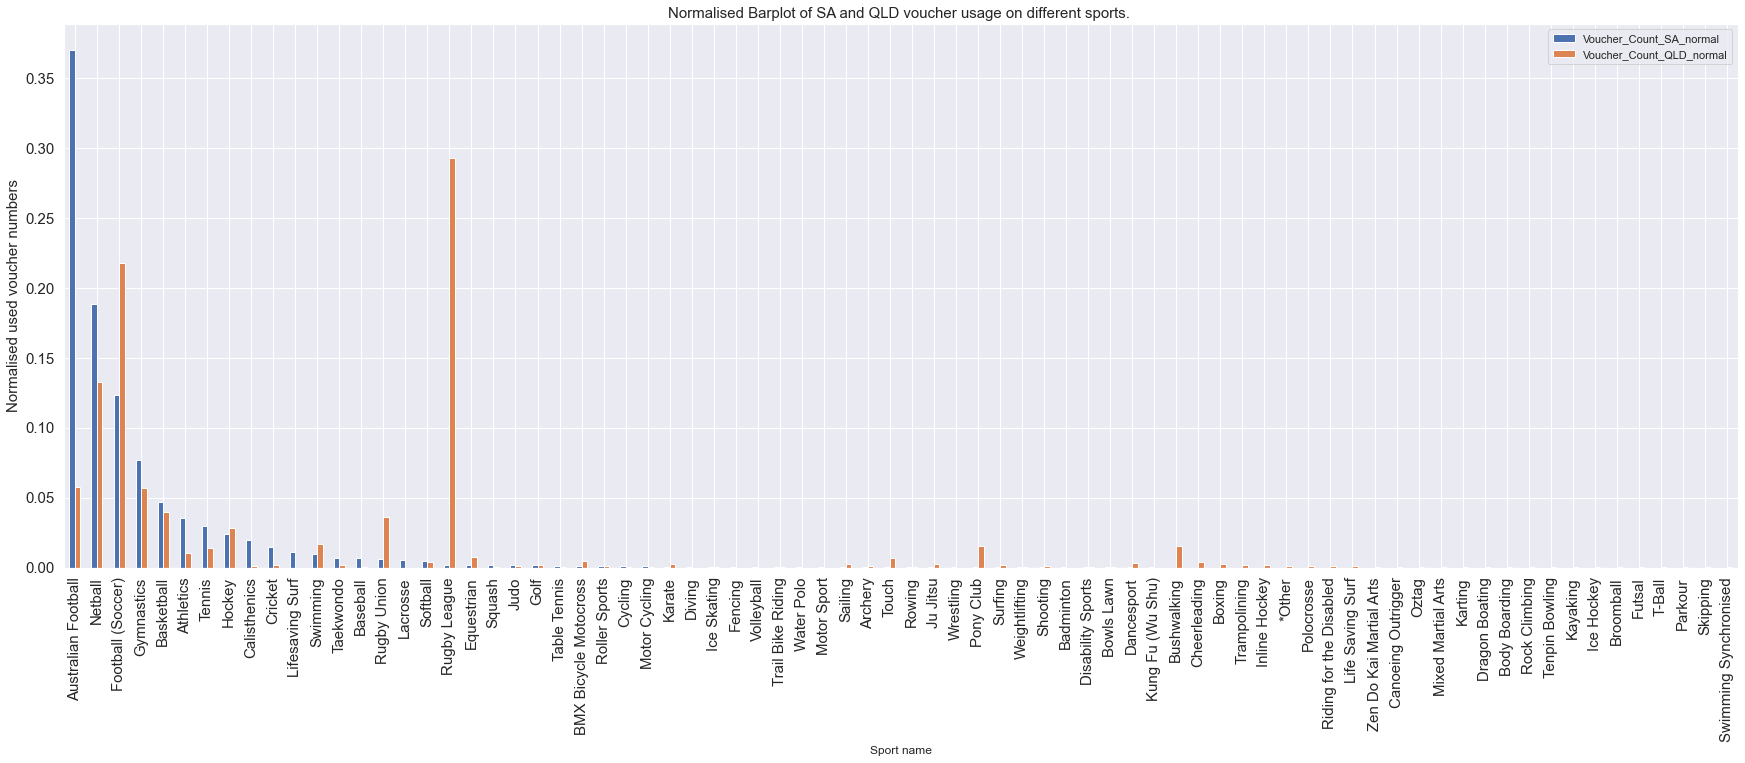

In [38]:
merged_df=pd.concat([sport_counts, qld_sport_counts], axis=1)
merged_df.plot(kind='bar', figsize=(30,10), fontsize=15)
plt.title("Normalised Barplot of SA and QLD voucher usage on different sports. ",fontsize=15);
plt.ylabel("Normalised used voucher numbers",fontsize=15)

We can see that in both States there is somewhat of a clustering in some sports. Netball, football, gymnastics basketball and hockey seem to be popular in both states. However there are striking differenes as well. Both Rugby Leage and Rugby Union seem to be popular in Queenland and not so much in South Australia. Similarly Australian Football is way more popular in South Australia than Quensland. Soccer on the other hand is more popular in Queensland than South Australia. There are also some sports that only recorded in QLD. <br>
We can see that the most popular two sports in South Australia are Australian Footbal and Netball whereas in QLD the most popular two sports are Rugby League and Soccer respectively. It would be interesting to look at other factors which might effect these differences of sport choice in QLD and SA such as history, population background etc.
